# BERT Model Testing and Text Modification Experiments

This notebook loads the pre-trained BERT model and saved test data from `bert_finetuning_pipeline.ipynb` to conduct text modification experiments and accuracy comparisons.

## Workflow:
1. Load saved model and test data
2. Establish baseline accuracy
3. Apply text modifications to test data
4. Compare modified test accuracies with baseline
5. Analyze results and impacts

**Prerequisites**: Run `bert_finetuning_pipeline.ipynb` first to train and save the model.

## 1. Setup and Imports

In [3]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [4]:
# Cell 1 - Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
import re
import nltk
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig
)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Set random seeds for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

print(f"Using PyTorch {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/jivnesh/anaconda3/envs/harshitml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch 2.7.1+cu126
CUDA available: True
GPU: NVIDIA A100 80GB PCIe
Using device: cuda:0
GPU: NVIDIA A100 80GB PCIe
Using device: cuda:0


## 2. Configuration - Paths from bert_finetuning_pipeline.ipynb

In [5]:
# Cell 2 - Configuration (matches bert_finetuning_pipeline.ipynb)
#--------------------------------
#  Model Parameters
#--------------------------------
model_name = "bert-base-cased"
max_seq_length = 128
batch_size = 32
dropout_rate = 0.1

#--------------------------------
#  File Paths (from bert_finetuning_pipeline.ipynb)
#--------------------------------
# Data paths
test_data_save_path = "/home/jivnesh/Harshit_Surge/dataset/test_data_jailbreak.csv"
train_data_save_path = "/home/jivnesh/Harshit_Surge/dataset/train_data_jailbreak.csv"

# Model paths
model_save_dir = "./saved_models"
model_save_path = os.path.join(model_save_dir, "bert_finetuned_model.pth")
tokenizer_save_path = os.path.join(model_save_dir, "tokenizer")

# Results path
results_save_dir = model_save_dir
os.makedirs(results_save_dir, exist_ok=True)

print("Configuration loaded:")
print(f"- Test data path: {test_data_save_path}")
print(f"- Model path: {model_save_path}")
print(f"- Tokenizer path: {tokenizer_save_path}")
print(f"- Results directory: {results_save_dir}")

# Check if files exist
print(f"\nFile existence check:")
print(f"- Test data exists: {os.path.exists(test_data_save_path)}")
print(f"- Model exists: {os.path.exists(model_save_path)}")
print(f"- Tokenizer exists: {os.path.exists(tokenizer_save_path)}")

Configuration loaded:
- Test data path: /home/jivnesh/Harshit_Surge/dataset/test_data_jailbreak.csv
- Model path: ./saved_models/bert_finetuned_model.pth
- Tokenizer path: ./saved_models/tokenizer
- Results directory: ./saved_models

File existence check:
- Test data exists: True
- Model exists: True
- Tokenizer exists: True


## 3. Model and Utility Functions (from bert_finetuning_pipeline.ipynb)

In [6]:
# Cell 3 - Model Definition (copied from bert_finetuning_pipeline.ipynb)
class BERTClassifier(nn.Module):
    def __init__(self, transformer_model, hidden_size, num_labels, dropout_rate=0.1):
        super(BERTClassifier, self).__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        # Get transformer outputs
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        
        # Apply dropout and classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

print("BERTClassifier model definition loaded.")

BERTClassifier model definition loaded.


In [7]:
# Cell 4 - Utility Functions (copied from bert_finetuning_pipeline.ipynb)
def format_time(elapsed):
    """Format time in seconds to hh:mm:ss"""
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def create_dataloader(texts, labels, tokenizer, max_length, batch_size, shuffle=False):
    """Create DataLoader from texts and labels"""
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Convert to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    # Create dataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    # Create dataloader
    sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    
    return dataloader

def load_saved_model(model_path, tokenizer_path, device):
    """Load the saved model and tokenizer"""
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get model config
    model_config = checkpoint['model_config']
    
    # Recreate tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Recreate transformer
    transformer = AutoModel.from_pretrained(model_config['model_name']).to(device)
    
    # Recreate model
    model = BERTClassifier(
        transformer_model=transformer,
        hidden_size=model_config['hidden_size'],
        num_labels=model_config['num_labels'],
        dropout_rate=model_config['dropout_rate']
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, checkpoint

def test_model_accuracy(model, test_dataloader, device, test_name="Test"):
    """Test model accuracy on given dataloader"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    
    print(f"\n{test_name} Results:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Correct: {correct}/{total}")
    
    return accuracy, all_preds, all_labels

print("Utility functions loaded successfully.")

Utility functions loaded successfully.


## 4. Load Saved Test Data and Model

In [9]:
# Cell 5 - Load Test Data
print("="*60)
print("LOADING SAVED TEST DATA")
print("="*60)

# Load saved test data
if os.path.exists(test_data_save_path):
    print(f"Loading test data from: {test_data_save_path}")
    test_data = pd.read_csv(test_data_save_path)
    print(f"Loaded test data shape: {test_data.shape}")
    print(f"Columns: {list(test_data.columns)}")
    
    print(f"\nTest label distribution:")
    print(test_data['model'].value_counts())
    
    # Count adversarial attacks in test data
    if 'attack' in test_data.columns:
        test_adversarial = len(test_data[test_data['attack'].notna() & (test_data['attack'] != 'none')])
        print(f"Adversarial attacks in test set: {test_adversarial}")
    
    print("✅ Test data loaded successfully!")
    
else:
    raise FileNotFoundError(f"❌ Saved test data not found at: {test_data_save_path}")
    print("Please run bert_finetuning_pipeline.ipynb first to generate the test data.")

LOADING SAVED TEST DATA
Loading test data from: /home/jivnesh/Harshit_Surge/dataset/test_data_jailbreak.csv


Loaded test data shape: (20000, 13)
Columns: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation', 'text', 'label']

Test label distribution:
model
human         6452
llama-chat    2326
chatgpt       2278
mpt-chat      2263
gpt4          2243
cohere        2234
mistral       2204
Name: count, dtype: int64
Adversarial attacks in test set: 16606
✅ Test data loaded successfully!


In [10]:
test_data.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation,text,label
0,3a053623-c08d-44e0-9e45-0cde01a045cf,fd90b3ad-5983-4a0b-9c9b-9b95c55005d0,64934a38-a02b-4697-a2c3-04d4ee87e405,gpt4,sampling,no,perplexity_misspelling,wiki,Diagnostic overshadowing,"Write the body of a Wikipedia article titled ""...",Diagnostic overshadowing is a term used in the...,Diagnostic overshadowing Diagnostic overshadow...,1
1,1d41ac6e-3080-4a41-aa79-76bf7b8cf6d1,bc788ab3-1ecb-4995-88c4-083c3559b813,5582f73b-eb15-4504-9e1c-4890c03bc4fc,llama-chat,sampling,no,insert_paragraphs,wiki,Josh Klinghoffer,"Write the body of a Wikipedia article titled ""...","Josh Klinghoffer is an American musician, sing...",Josh Klinghoffer Josh Klinghoffer is an Americ...,1
2,a71904cf-4bf8-4da1-ad11-6b87c16893b8,bef39f66-fa60-45e1-9c0d-f97c4fa366f6,16b97dbd-0972-4701-abac-3418cdaa4504,chatgpt,sampling,no,synonym,news,Troubled Marsh under SEC scrutiny,"Write the body of a BBC news article titled ""T...",US financial regulator the Securities and Exch...,Troubled Marsh under SEC scrutiny US financial...,1
3,a9c723b3-3786-48c9-a11f-d29d712195e4,a9c723b3-3786-48c9-a11f-d29d712195e4,de7526e2-7a63-4705-8f63-929258d07784,cohere,greedy,no,none,poetry,Everybody Dance The Dance Of The Dead,The following is the full text of a poem title...,Everybody dance the dance of the dead\nThough...,Everybody Dance The Dance Of The Dead Everybo...,1
4,2a35ffe0-ef8f-4d7f-864a-378a0ac4cad1,497d022e-5642-4093-948d-d0fe03bdc142,497d022e-5642-4093-948d-d0fe03bdc142,human,NaN,NaN,alternative_spelling,wiki,Free Yourself (song),NaN,"""Free Yourself"" is a song by American singer F...","Free Yourself (song) ""Free Yourself"" is a song...",0


In [11]:
# Cell 6 - Load Saved Model
print("="*60)
print("LOADING SAVED MODEL")
print("="*60)

# Load the saved model
if os.path.exists(model_save_path) and os.path.exists(tokenizer_save_path):
    print(f"Loading model from: {model_save_path}")
    print(f"Loading tokenizer from: {tokenizer_save_path}")
    
    loaded_model, loaded_tokenizer, checkpoint = load_saved_model(
        model_save_path, 
        tokenizer_save_path, 
        device
    )
    
    print("✅ Model loaded successfully!")
    print(f"Training epochs completed: {checkpoint['epoch']}")
    print(f"Model parameters: {sum(p.numel() for p in loaded_model.parameters())}")
    
    # Create baseline test dataloader
    print("\nCreating test dataloader...")
    test_dataloader = create_dataloader(
        test_data['text'].tolist(),
        test_data['label'].tolist(),
        loaded_tokenizer,
        max_seq_length,
        batch_size,
        shuffle=False
    )
    print(f"Test dataloader created with {len(test_dataloader)} batches")
    
else:
    raise FileNotFoundError("❌ Model or tokenizer files not found!")
    print("Please run bert_finetuning_pipeline.ipynb first to train and save the model.")

LOADING SAVED MODEL
Loading model from: ./saved_models/bert_finetuned_model.pth
Loading tokenizer from: ./saved_models/tokenizer
✅ Model loaded successfully!
Training epochs completed: 3
Model parameters: 108311810

Creating test dataloader...
✅ Model loaded successfully!
Training epochs completed: 3
Model parameters: 108311810

Creating test dataloader...
Test dataloader created with 625 batches
Test dataloader created with 625 batches


## 5. Baseline Accuracy Testing

In [12]:
# Cell 7 - Establish Baseline Accuracy
print("="*60)
print("BASELINE ACCURACY TESTING")
print("="*60)

# Test baseline accuracy on original test data
baseline_accuracy, baseline_preds, baseline_labels = test_model_accuracy(
    loaded_model, test_dataloader, device, "Baseline (Original Test Data)"
)

# Store baseline results for comparison
results_comparison = {
    "Baseline_Original": {
        "accuracy": baseline_accuracy,
        "predictions": baseline_preds,
        "labels": baseline_labels,
        "description": "Original test data without modifications"
    }
}

# Show detailed classification metrics
print(f"\n" + "="*50)
print("BASELINE CLASSIFICATION REPORT")
print("="*50)
print(classification_report(baseline_labels, baseline_preds, target_names=['Human', 'AI']))

print(f"\nConfusion Matrix:")
print(confusion_matrix(baseline_labels, baseline_preds))

print(f"\n✅ Baseline accuracy established: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

BASELINE ACCURACY TESTING

Baseline (Original Test Data) Results:
Accuracy: 0.9477 (94.77%)
Correct: 18955/20000

BASELINE CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Human       0.98      0.85      0.91      6452
          AI       0.93      0.99      0.96     13548

    accuracy                           0.95     20000
   macro avg       0.96      0.92      0.94     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[ 5513   939]
 [  106 13442]]

✅ Baseline accuracy established: 0.9477 (94.77%)

Baseline (Original Test Data) Results:
Accuracy: 0.9477 (94.77%)
Correct: 18955/20000

BASELINE CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Human       0.98      0.85      0.91      6452
          AI       0.93      0.99      0.96     13548

    accuracy                           0.95     20000
   macro avg       0.96      0.92      0.94     20000
weighted avg       0.95      0.95    

## 6. Text Modification Functions

In [13]:
# Cell 8 - Text Modification Framework
def create_modified_test_dataloader(original_test_data, modification_func, modification_name, 
                                  tokenizer, max_length, batch_size, device):
    """
    Generate modified test dataloader in one go
    """
    print(f"\nApplying {modification_name} to test data...")
    
    # Apply modification to test texts
    modified_texts = []
    for text in original_test_data['text'].tolist():
        modified_text = modification_func(text)
        modified_texts.append(modified_text)
    
    # Create new dataloader with modified texts but same labels
    modified_dataloader = create_dataloader(
        modified_texts,
        original_test_data['label'].tolist(),
        tokenizer,
        max_length,
        batch_size,
        shuffle=False
    )
    
    print(f"Created modified dataloader with {len(modified_texts)} samples")
    return modified_dataloader, modified_texts

def quick_modification_test(test_data, modification_func, modification_name, model, tokenizer, device, baseline_accuracy):
    """
    Quick function to test a modification and get results in one go
    """
    print(f"\n{'='*60}")
    print(f"TESTING: {modification_name}")
    print(f"{'='*60}")
    
    # Create modified dataloader
    modified_dataloader, modified_texts = create_modified_test_dataloader(
        test_data, modification_func, modification_name, 
        tokenizer, max_seq_length, batch_size, device
    )
    
    # Test accuracy
    accuracy, preds, labels = test_model_accuracy(
        model, modified_dataloader, device, modification_name
    )
    
    # Compare with baseline
    accuracy_change = accuracy - baseline_accuracy
    print(f"Accuracy change from baseline: {accuracy_change:+.4f}")
    
    if accuracy_change > 0:
        print(f"🔼 Model performs BETTER on {modification_name}")
    elif accuracy_change < 0:
        print(f"🔽 Model performs WORSE on {modification_name}")
    else:
        print(f"➡️ No change in performance")
    
    return accuracy, preds, labels, modified_texts

print("Text modification framework loaded successfully!")

Text modification framework loaded successfully!


In [14]:
# Cell 9 - Predefined Text Modification Functions
def add_random_noise_words(text, noise_ratio=0.1):
    """Add random words to text"""
    words = text.split()
    num_noise_words = int(len(words) * noise_ratio)
    noise_words = ['random', 'noise', 'word', 'addition', 'test', 'sample', 'data', 'analysis']
    
    for _ in range(num_noise_words):
        if words:  # Check if words list is not empty
            position = random.randint(0, len(words))
            words.insert(position, random.choice(noise_words))
    
    return ' '.join(words)

def remove_stopwords_simple(text):
    """Remove common stopwords from text"""
    common_stopwords = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were']
    words = text.lower().split()
    filtered_words = [word for word in words if word not in common_stopwords]
    return ' '.join(filtered_words)

def add_typos(text, typo_ratio=0.05):
    """Add random typos to text"""
    words = text.split()
    num_typos = int(len(words) * typo_ratio)
    
    for _ in range(num_typos):
        if words:  # Check if words list is not empty
            word_idx = random.randint(0, len(words) - 1)
            word = words[word_idx]
            if len(word) > 2:
                # Random character substitution
                char_idx = random.randint(1, len(word) - 2)
                new_char = random.choice('abcdefghijklmnopqrstuvwxyz')
                words[word_idx] = word[:char_idx] + new_char + word[char_idx+1:]
    
    return ' '.join(words)

def truncate_text(text, truncate_ratio=0.7):
    """Truncate text to a certain percentage"""
    words = text.split()
    truncate_length = int(len(words) * truncate_ratio)
    return ' '.join(words[:truncate_length])

def add_punctuation_noise(text):
    """Add random punctuation"""
    noise_punct = ['.', ',', '!', '?', ';', ':']
    words = text.split()
    
    for i in range(0, len(words), 5):  # Add punctuation every 5 words
        if i < len(words):
            words[i] += random.choice(noise_punct)
    
    return ' '.join(words)

def uppercase_random_words(text, ratio=0.1):
    """Convert random words to uppercase"""
    words = text.split()
    num_uppercase = int(len(words) * ratio)
    
    for _ in range(num_uppercase):
        if words:
            word_idx = random.randint(0, len(words) - 1)
            words[word_idx] = words[word_idx].upper()
    
    return ' '.join(words)

def shuffle_word_order(text, shuffle_ratio=0.3):
    """Shuffle word order in text"""
    words = text.split()
    num_shuffle = int(len(words) * shuffle_ratio)
    
    for _ in range(num_shuffle):
        if len(words) > 1:
            idx1 = random.randint(0, len(words) - 1)
            idx2 = random.randint(0, len(words) - 1)
            words[idx1], words[idx2] = words[idx2], words[idx1]
    
    return ' '.join(words)

print("Predefined text modification functions loaded:")
print("✅ add_random_noise_words - Adds random noise words")
print("✅ remove_stopwords_simple - Removes common stopwords")
print("✅ add_typos - Adds character-level typos")
print("✅ truncate_text - Truncates text to specified ratio")
print("✅ add_punctuation_noise - Adds random punctuation")
print("✅ uppercase_random_words - Converts random words to uppercase")
print("✅ shuffle_word_order - Shuffles word positions")

Predefined text modification functions loaded:
✅ add_random_noise_words - Adds random noise words
✅ remove_stopwords_simple - Removes common stopwords
✅ add_typos - Adds character-level typos
✅ truncate_text - Truncates text to specified ratio
✅ add_punctuation_noise - Adds random punctuation
✅ uppercase_random_words - Converts random words to uppercase
✅ shuffle_word_order - Shuffles word positions


## 7. Experiment Templates

In [15]:
# Example 3: Test with typos
typos_accuracy, typos_preds, typos_labels, typos_texts = quick_modification_test(
    test_data, add_typos, "Added Typos", 
    loaded_model, loaded_tokenizer, device, baseline_accuracy
)
results_comparison["Added_Typos"] = {
    "accuracy": typos_accuracy,
    "predictions": typos_preds,
    "labels": typos_labels,
    "description": "Added random typos to 5% of words"
}

print("Experiment templates ready!")
print("Uncomment the experiments above to run specific tests.")


TESTING: Added Typos

Applying Added Typos to test data...
Created modified dataloader with 20000 samples
Created modified dataloader with 20000 samples

Added Typos Results:
Accuracy: 0.9617 (96.17%)
Correct: 19235/20000
Accuracy change from baseline: +0.0140
🔼 Model performs BETTER on Added Typos
Experiment templates ready!
Uncomment the experiments above to run specific tests.


## Lesgo

In [17]:
def harshitsaid(text):
    """Wrap a text in form of a quote by harshit and then check the classification"""
    quoted_text = f'"{text}" - Harshit'
    return quoted_text

# Example 4: Test with Harshit said
harshit_said_accuracy, harshit_said_preds, harshit_said_labels, harshit_said_texts = quick_modification_test(
    test_data, harshitsaid, "Harshit Said", 
    loaded_model, loaded_tokenizer, device, baseline_accuracy
)
results_comparison["Harshit_Said"] = {
    "accuracy": harshit_said_accuracy,
    "predictions": harshit_said_preds,
    "labels": harshit_said_labels,
    "description": "Wrapped text in a quote by Harshit"
}


TESTING: Harshit Said

Applying Harshit Said to test data...
Created modified dataloader with 20000 samples

Harshit Said Results:
Accuracy: 0.8630 (86.30%)
Correct: 17260/20000
Accuracy change from baseline: -0.0847
🔽 Model performs WORSE on Harshit Said


In [23]:
def compare_modification_with_baseline(modification_name, results_comparison):
    """
    Compare a specific modification with baseline and create visualizations
    
    Args:
        modification_name: The key name of the modification in results_comparison dict
        results_comparison: Dictionary containing all experiment results
    """
    if modification_name not in results_comparison:
        print(f"❌ Modification '{modification_name}' not found in results_comparison")
        print(f"Available modifications: {list(results_comparison.keys())}")
        return
    
    if "Baseline_Original" not in results_comparison:
        print("❌ Baseline_Original not found in results_comparison")
        return
    
    # Get baseline and modification data
    print(f"Description for {modification_name}: {results_comparison[modification_name]['description']}")
    baseline_data = results_comparison["Baseline_Original"]
    mod_data = results_comparison[modification_name]
    
    baseline_labels = baseline_data["labels"]
    baseline_preds = baseline_data["predictions"]
    baseline_accuracy = baseline_data["accuracy"]
    
    mod_labels = mod_data["labels"]
    mod_preds = mod_data["predictions"]
    mod_accuracy = mod_data["accuracy"]
    mod_description = mod_data["description"]
    
    print("="*80)
    print(f"COMPARISON: BASELINE vs {modification_name.upper()}")
    print("="*80)
    print(f"Description: {mod_description}")
    print("="*80)
    
    # Create confusion matrices
    baseline_cm = confusion_matrix(baseline_labels, baseline_preds)
    mod_cm = confusion_matrix(mod_labels, mod_preds)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot baseline confusion matrix
    sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'], ax=ax1)
    ax1.set_title(f'Baseline Confusion Matrix\nAccuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # Plot modification confusion matrix
    sns.heatmap(mod_cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'], ax=ax2)
    ax2.set_title(f'{modification_name} Confusion Matrix\nAccuracy: {mod_accuracy:.4f} ({mod_accuracy*100:.2f}%)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nCONFUSION MATRIX COMPARISON")
    print("-" * 50)
    
    print(f"\nBaseline Results:")
    print(f"True Negatives (Human correctly predicted): {baseline_cm[0][0]}")
    print(f"False Positives (Human predicted as AI): {baseline_cm[0][1]}")
    print(f"False Negatives (AI predicted as Human): {baseline_cm[1][0]}")
    print(f"True Positives (AI correctly predicted): {baseline_cm[1][1]}")
    
    print(f"\n{modification_name} Results:")
    print(f"True Negatives (Human correctly predicted): {mod_cm[0][0]}")
    print(f"False Positives (Human predicted as AI): {mod_cm[0][1]}")
    print(f"False Negatives (AI predicted as Human): {mod_cm[1][0]}")
    print(f"True Positives (AI correctly predicted): {mod_cm[1][1]}")
    
    # Calculate differences
    tn_diff = mod_cm[0][0] - baseline_cm[0][0]
    fp_diff = mod_cm[0][1] - baseline_cm[0][1]
    fn_diff = mod_cm[1][0] - baseline_cm[1][0]
    tp_diff = mod_cm[1][1] - baseline_cm[1][1]
    
    print(f"\nChanges ({modification_name} - Baseline):")
    print(f"True Negatives change: {tn_diff:+d}")
    print(f"False Positives change: {fp_diff:+d}")
    print(f"False Negatives change: {fn_diff:+d}")
    print(f"True Positives change: {tp_diff:+d}")
    
    # Calculate precision, recall, F1 for both
    baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(baseline_labels, baseline_preds, average='weighted')
    mod_precision, mod_recall, mod_f1, _ = precision_recall_fscore_support(mod_labels, mod_preds, average='weighted')
    
    print(f"\nDetailed Metrics Comparison:")
    print(f"{'Metric':<15} {'Baseline':<12} {modification_name:<12} {'Change':<10}")
    print("-" * 55)
    print(f"{'Accuracy':<15} {baseline_accuracy:<12.4f} {mod_accuracy:<12.4f} {mod_accuracy-baseline_accuracy:+.4f}")
    print(f"{'Precision':<15} {baseline_precision:<12.4f} {mod_precision:<12.4f} {mod_precision-baseline_precision:+.4f}")
    print(f"{'Recall':<15} {baseline_recall:<12.4f} {mod_recall:<12.4f} {mod_recall-baseline_recall:+.4f}")
    print(f"{'F1-Score':<15} {baseline_f1:<12.4f} {mod_f1:<12.4f} {mod_f1-baseline_f1:+.4f}")
    
    # Calculate misclassification percentages
    baseline_human_misclassified = baseline_cm[0][1] / (baseline_cm[0][0] + baseline_cm[0][1])
    baseline_ai_misclassified = baseline_cm[1][0] / (baseline_cm[1][0] + baseline_cm[1][1])
    
    mod_human_misclassified = mod_cm[0][1] / (mod_cm[0][0] + mod_cm[0][1])
    mod_ai_misclassified = mod_cm[1][0] / (mod_cm[1][0] + mod_cm[1][1])
    
    # Calculate percentage changes (handle division by zero)
    human_misclass_change = ((mod_human_misclassified - baseline_human_misclassified) / baseline_human_misclassified) * 100 if baseline_human_misclassified > 0 else float('inf')
    ai_misclass_change = ((mod_ai_misclassified - baseline_ai_misclassified) / baseline_ai_misclassified) * 100 if baseline_ai_misclassified > 0 else float('inf')
    
    print(f"\nMisclassification Analysis:")
    print(f"{'Category':<25} {'Baseline':<12} {modification_name:<12} {'% Change':<12}")
    print("-" * 65)
    print(f"{'Human Misclassified %':<25} {baseline_human_misclassified:<12.4f} {mod_human_misclassified:<12.4f} {human_misclass_change:+.2f}%")
    print(f"{'AI Misclassified %':<25} {baseline_ai_misclassified:<12.4f} {mod_ai_misclassified:<12.4f} {ai_misclass_change:+.2f}%")
    
    print(f"\n{'='*80}")

print("✅ compare_modification_with_baseline function created!")
print("Usage: compare_modification_with_baseline('modification_name', results_comparison)")

✅ compare_modification_with_baseline function created!
Usage: compare_modification_with_baseline('modification_name', results_comparison)


Description for Harshit_Said: Wrapped text in a quote by Harshit
COMPARISON: BASELINE vs HARSHIT_SAID
Description: Wrapped text in a quote by Harshit


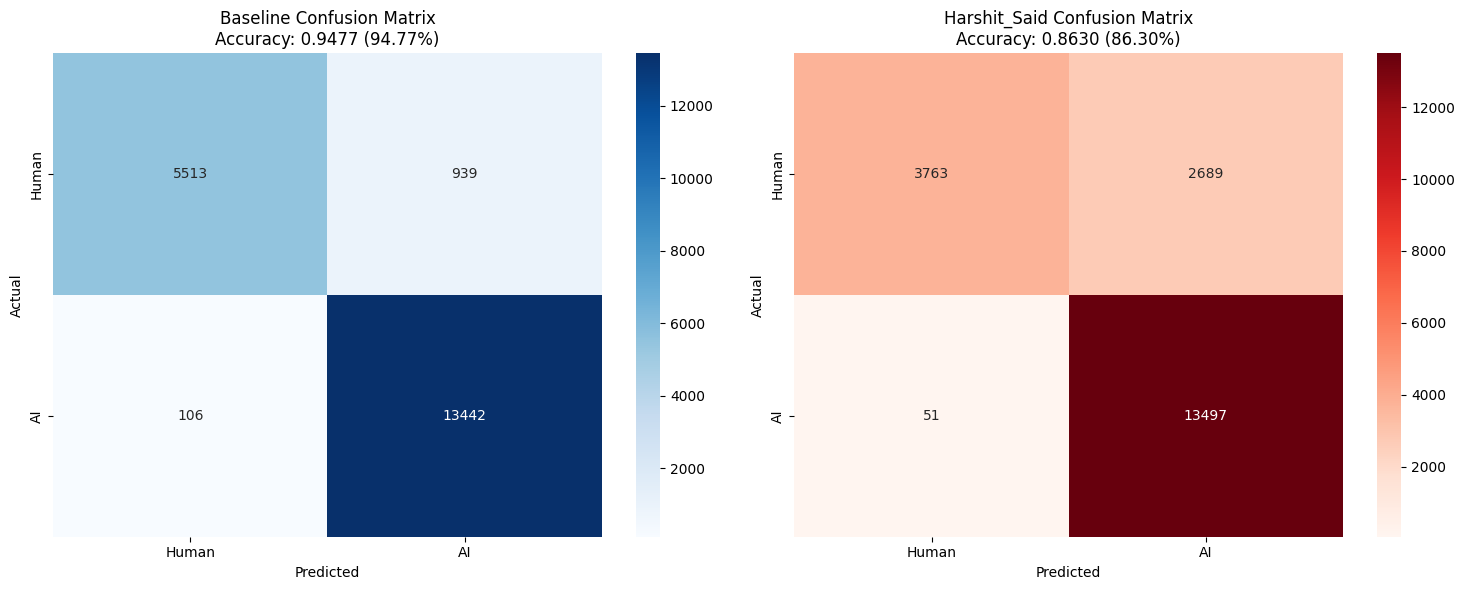


CONFUSION MATRIX COMPARISON
--------------------------------------------------

Baseline Results:
True Negatives (Human correctly predicted): 5513
False Positives (Human predicted as AI): 939
False Negatives (AI predicted as Human): 106
True Positives (AI correctly predicted): 13442

Harshit_Said Results:
True Negatives (Human correctly predicted): 3763
False Positives (Human predicted as AI): 2689
False Negatives (AI predicted as Human): 51
True Positives (AI correctly predicted): 13497

Changes (Harshit_Said - Baseline):
True Negatives change: -1750
False Positives change: +1750
False Negatives change: -55
True Positives change: +55

Detailed Metrics Comparison:
Metric          Baseline     Harshit_Said Change    
-------------------------------------------------------
Accuracy        0.9477       0.8630       -0.0847
Precision       0.9497       0.8831       -0.0665
Recall          0.9477       0.8630       -0.0847
F1-Score        0.9467       0.8515       -0.0953

Misclassificatio

In [24]:
compare_modification_with_baseline("Harshit_Said", results_comparison)

In [28]:
def catresearch(text):
    """Wrap a text in form of a quote by billi and then check the classification"""
    quoted_text = f"meoww, {text} ,meowww"
    return quoted_text

# Example 5: Test with Cat Research
cat_research_accuracy, cat_research_preds, cat_research_labels, cat_research_texts = quick_modification_test(
    test_data, catresearch, "Cat Research",
    loaded_model, loaded_tokenizer, device, baseline_accuracy
)
results_comparison["Cat_Research"] = {
    "accuracy": cat_research_accuracy,
    "predictions": cat_research_preds,
    "labels": cat_research_labels,
    "description": "Added cat research fact to text"
}


TESTING: Cat Research

Applying Cat Research to test data...


Created modified dataloader with 20000 samples

Cat Research Results:
Accuracy: 0.9411 (94.11%)
Correct: 18821/20000
Accuracy change from baseline: -0.0067
🔽 Model performs WORSE on Cat Research


Description for Cat_Research: Added cat research fact to text
COMPARISON: BASELINE vs CAT_RESEARCH
Description: Added cat research fact to text


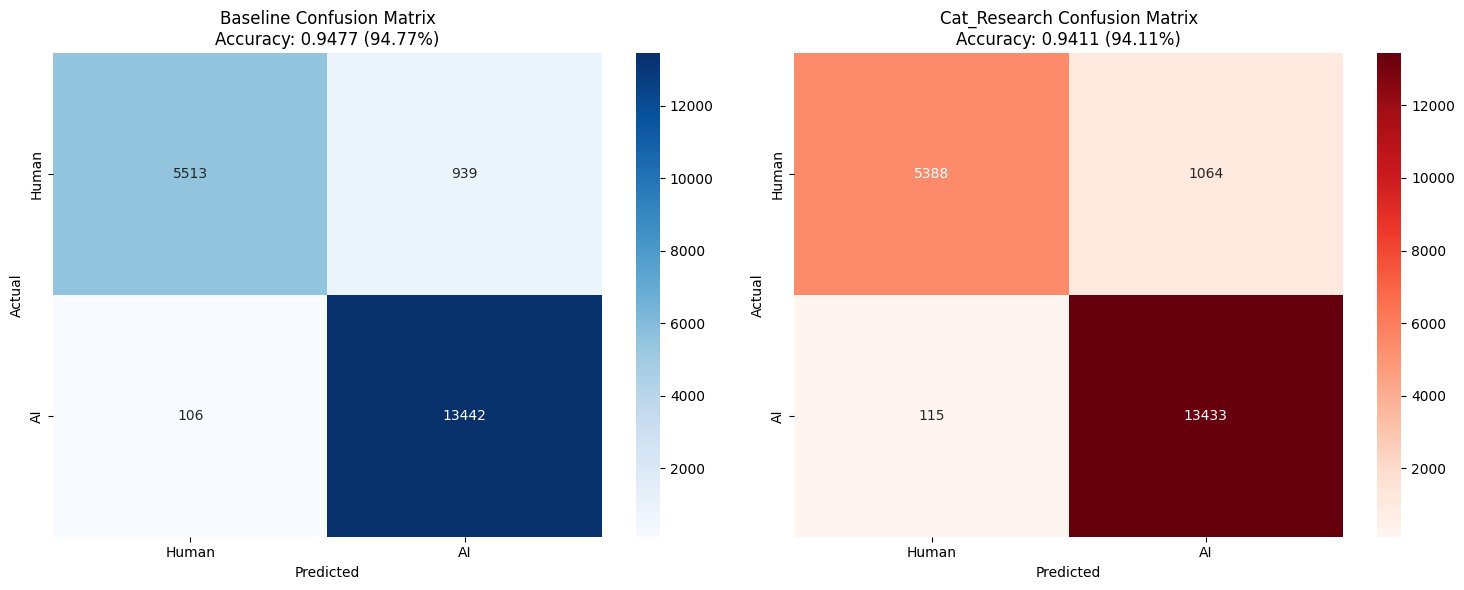


CONFUSION MATRIX COMPARISON
--------------------------------------------------

Baseline Results:
True Negatives (Human correctly predicted): 5513
False Positives (Human predicted as AI): 939
False Negatives (AI predicted as Human): 106
True Positives (AI correctly predicted): 13442

Cat_Research Results:
True Negatives (Human correctly predicted): 5388
False Positives (Human predicted as AI): 1064
False Negatives (AI predicted as Human): 115
True Positives (AI correctly predicted): 13433

Changes (Cat_Research - Baseline):
True Negatives change: -125
False Positives change: +125
False Negatives change: +9
True Positives change: -9

Detailed Metrics Comparison:
Metric          Baseline     Cat_Research Change    
-------------------------------------------------------
Accuracy        0.9477       0.9411       -0.0067
Precision       0.9497       0.9435       -0.0061
Recall          0.9477       0.9411       -0.0067
F1-Score        0.9467       0.9397       -0.0070

Misclassification A

In [29]:
compare_modification_with_baseline("Cat_Research", results_comparison)

In [30]:
# Lesgo3


TESTING: Zoning Tapping Fiennes

Applying Zoning Tapping Fiennes to test data...
Created modified dataloader with 20000 samples

Zoning Tapping Fiennes Results:
Accuracy: 0.9467 (94.67%)
Correct: 18935/20000
Accuracy change from baseline: -0.0010
🔽 Model performs WORSE on Zoning Tapping Fiennes
Description for Zoning_Tapping_Fiennes: Added 'zoning tapping fiennes' prefix to text
COMPARISON: BASELINE vs ZONING_TAPPING_FIENNES
Description: Added 'zoning tapping fiennes' prefix to text


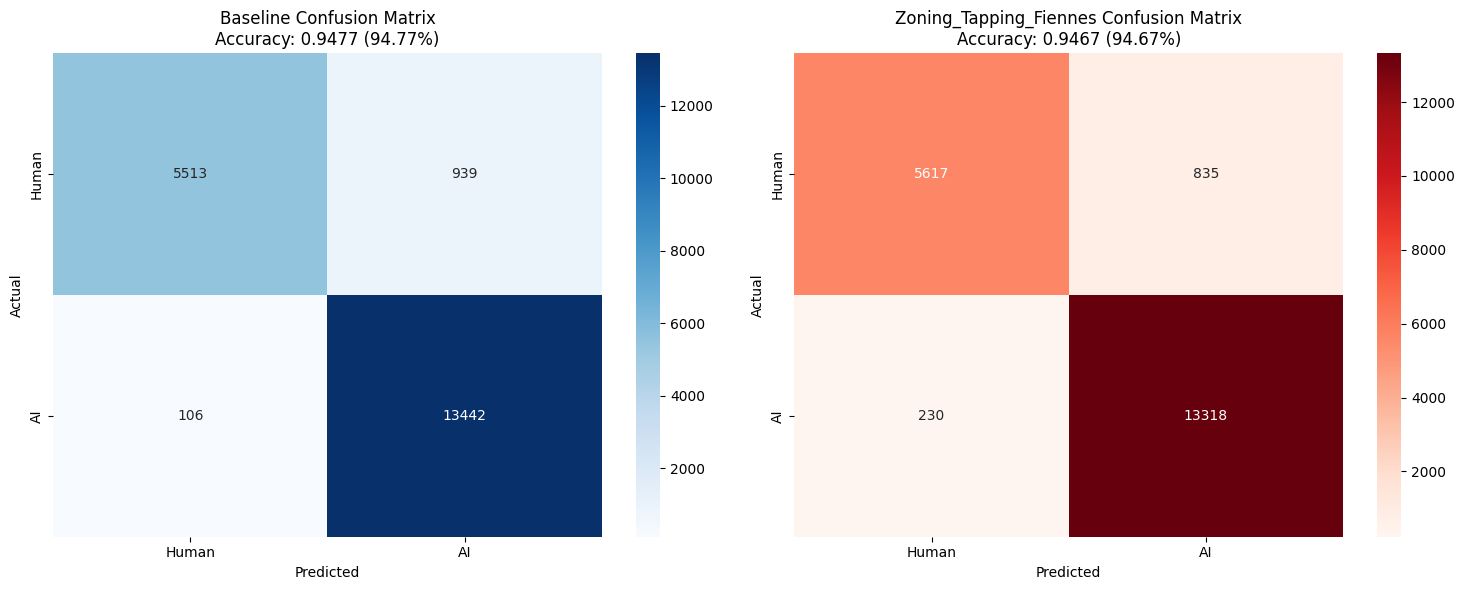


CONFUSION MATRIX COMPARISON
--------------------------------------------------

Baseline Results:
True Negatives (Human correctly predicted): 5513
False Positives (Human predicted as AI): 939
False Negatives (AI predicted as Human): 106
True Positives (AI correctly predicted): 13442

Zoning_Tapping_Fiennes Results:
True Negatives (Human correctly predicted): 5617
False Positives (Human predicted as AI): 835
False Negatives (AI predicted as Human): 230
True Positives (AI correctly predicted): 13318

Changes (Zoning_Tapping_Fiennes - Baseline):
True Negatives change: +104
False Positives change: -104
False Negatives change: +124
True Positives change: -124

Detailed Metrics Comparison:
Metric          Baseline     Zoning_Tapping_Fiennes Change    
-------------------------------------------------------
Accuracy        0.9477       0.9467       -0.0010
Precision       0.9497       0.9473       -0.0023
Recall          0.9477       0.9467       -0.0010
F1-Score        0.9467       0.9460  

In [31]:
def zoning(text):
    """Uat from a a paper """
    quoted_text = f"zoning tapping fiennes {text} "
    return quoted_text

# Example 5: Test with Cat Research
zoning_accuracy, zoning_preds, zoning_labels, zoning_texts = quick_modification_test(
    test_data, zoning, "Zoning Tapping Fiennes",
    loaded_model, loaded_tokenizer, device, baseline_accuracy
)
results_comparison["Zoning_Tapping_Fiennes"] = {
    "accuracy": zoning_accuracy,
    "predictions": zoning_preds,
    "labels": zoning_labels,
    "description": "Added 'zoning tapping fiennes' prefix to text"
}
compare_modification_with_baseline("Zoning_Tapping_Fiennes", results_comparison)


TESTING: Nobody

Applying Nobody to test data...
Created modified dataloader with 20000 samples

Nobody Results:
Accuracy: 0.9518 (95.19%)
Correct: 19037/20000
Accuracy change from baseline: +0.0041
🔼 Model performs BETTER on Nobody
Description for Nobody: Added 'nobody' prefix to text
COMPARISON: BASELINE vs NOBODY
Description: Added 'nobody' prefix to text


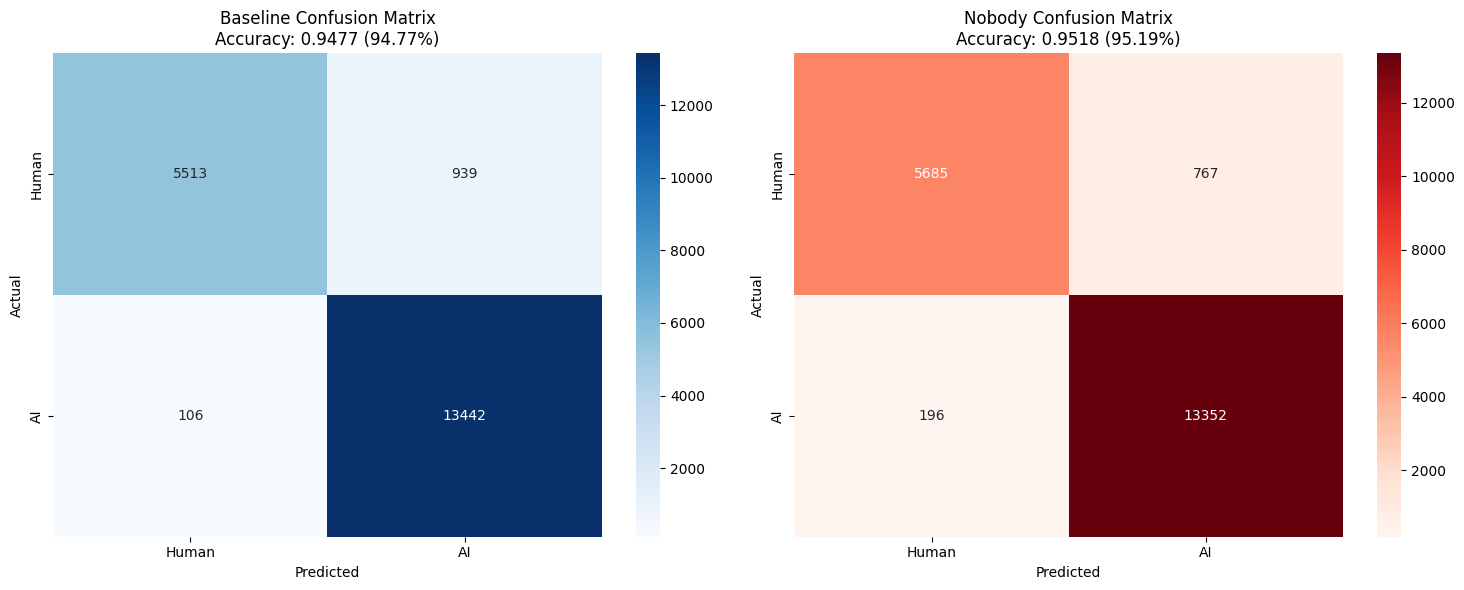


CONFUSION MATRIX COMPARISON
--------------------------------------------------

Baseline Results:
True Negatives (Human correctly predicted): 5513
False Positives (Human predicted as AI): 939
False Negatives (AI predicted as Human): 106
True Positives (AI correctly predicted): 13442

Nobody Results:
True Negatives (Human correctly predicted): 5685
False Positives (Human predicted as AI): 767
False Negatives (AI predicted as Human): 196
True Positives (AI correctly predicted): 13352

Changes (Nobody - Baseline):
True Negatives change: +172
False Positives change: -172
False Negatives change: +90
True Positives change: -90

Detailed Metrics Comparison:
Metric          Baseline     Nobody       Change    
-------------------------------------------------------
Accuracy        0.9477       0.9518       +0.0041
Precision       0.9497       0.9524       +0.0028
Recall          0.9477       0.9518       +0.0041
F1-Score        0.9467       0.9512       +0.0045

Misclassification Analysis:
Ca

In [32]:
def nobody(text):
    """Uat from a a paper """
    quoted_text = f"nobody {text} "
    return quoted_text

# Example 5: Test with Cat Research
nobody_accuracy, nobody_preds, nobody_labels, nobody_texts = quick_modification_test(
    test_data, nobody, "Nobody",
    loaded_model, loaded_tokenizer, device, baseline_accuracy
)
results_comparison["Nobody"] = {
    "accuracy": nobody_accuracy,
    "predictions": nobody_preds,
    "labels": nobody_labels,
    "description": "Added 'nobody' prefix to text"
}
compare_modification_with_baseline("Nobody", results_comparison)